<a href="https://colab.research.google.com/github/SohanVerma12/Amazon-Recommendation-Systems-for-Ratings/blob/main/Amazon%20Recommendation%20Systems%20for%20Ratings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
pip install joblib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
# import library for our project
import pandas as pd
import numpy as np
import math
import json
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
#from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
%matplotlib inline


In [35]:
# reading the data
# electronics_data=pd.read_csv("ratings_Electronics.csv",names=['userId', 'productId','Rating','timestamp'])
# We added columns names as the original dataset did not have.
columns=['userId', 'productId', 'ratings','timestamp']
df=pd.read_csv(r"/content/ratings_Electronics.csv",names=columns)

In [36]:
df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [37]:
# Dropping the timestamp column
df.drop('timestamp',axis=1,inplace=True)

In [38]:
df.head()

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [39]:
# Statistics about ratings coloumn
df.describe()

,ratings
count,386580.000000
mean,3.983354
std,1.393513
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [40]:
# from the above output, the ratings is distributed fomr 1 to 5, with one being the lowest 
# we take subset of the dataset as the data size is too large to make it less dense
df1=df.iloc[:1000005,0:]

In [41]:
df1

,userId,productId,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0
...,...,...,...
386575,A3ISVYONRK0TPQ,B0001FTVEK,5.0
386576,A2T68Z4XJGKYMJ,B0001FTVEK,5.0
386577,A2PPL1ZY0G5HRW,B0001FTVEK,3.0
386578,A16Z5TO2W1GYMA,B0001FTVEK,4.0


In [42]:
# handling the missing values
df1.isnull().sum()

userId       0
productId    0
ratings      0
dtype: int64

In [43]:
# you see that there is not a single value is null

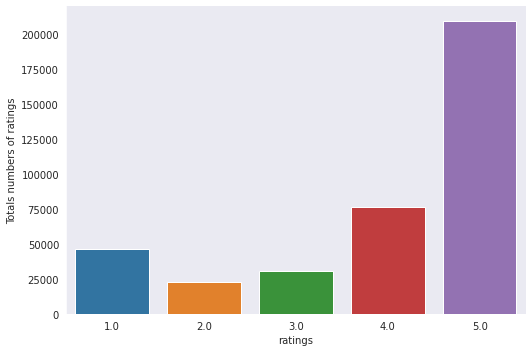

In [44]:
# Distribution of ratings
with sns.axes_style('dark'):
    # g = sns.catplot(data = df1, aspect = 1.0)
    g = sns.catplot( x='ratings',kind="count", data=df,aspect=1.5)
    g.set_ylabels('Totals numbers of ratings')

In [45]:
# now we see that most of the users are give rating of 5.0

In [46]:
# Unique User and Products
print("\nTotal no of Ratings:", df1.shape[0])
print("\nTotal no of Users:", len(np.unique(df1.userId)))
print("\nTotal no of Products:", len(np.unique(df1.productId)))


Total no of Ratings: 386580

Total no of Users: 318173

Total no of Products: 24440


In [47]:
# Analyzing the rating given by users
rating_byuser = df1.groupby(by='userId')['ratings'].count().sort_values(ascending=False)[:10]
print("Top 10 users based on ratings:\n", rating_byuser)

Top 10 users based on ratings:
 userId
A231WM2Z2JL0U3    244
A5JLAU2ARJ0BO     236
A25HBO5V8S8SEA    145
AKT8TGIT6VVZ5      79
A2AEZQ3DGBBLPR     73
A6FIAB28IS79       69
ABH9D1TEOJ56E      64
A11D1KHM7DVOQK     63
A2B7BUH8834Y6M     60
AT2J7H5TRZM8Z      57
Name: ratings, dtype: int64


In [48]:
# as the dataset is very large. so we considers only top 50 user ratings who rated more than 50
new_df = df1.groupby('productId').filter(lambda x:x['ratings'].count()>=50)


In [49]:
new_df

,userId,productId,ratings
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
...,...,...,...
386575,A3ISVYONRK0TPQ,B0001FTVEK,5.0
386576,A2T68Z4XJGKYMJ,B0001FTVEK,5.0
386577,A2PPL1ZY0G5HRW,B0001FTVEK,3.0
386578,A16Z5TO2W1GYMA,B0001FTVEK,4.0


In [50]:
new_df.shape

(239325, 3)

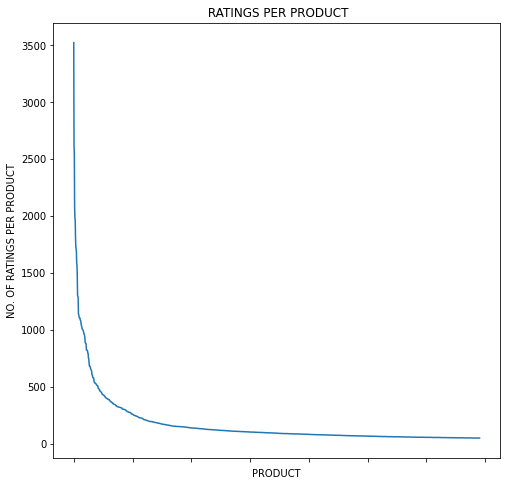

In [51]:
no_of_ratings_per_product = new_df.groupby(by='productId')['ratings'].count().sort_values(ascending=False)
plt.figure(figsize=(8,8))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title(' RATINGS PER PRODUCT')
plt.xlabel('PRODUCT')
plt.ylabel('NO. OF RATINGS PER PRODUCT')
ax.set_xticklabels([])

plt.show()

In [52]:
# creating a pivot table
new_df1 = new_df.head(10000)

ratings_matrix = new_df1.pivot_table(values='ratings', index = 'userId',
                                    columns = 'productId', fill_value=0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
new_df1

,userId,productId,ratings
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0
...,...,...,...
18221,AA0QP6NV5XCS,B00000K135,5.0
18222,A2MXK2BL6EFOPR,B00000K135,5.0
18223,A38WZ0ITR34AFN,B00000K135,5.0
18224,A1TOKV97O1JR00,B00000K135,5.0


In [54]:
# shown in the table, many cells are fixed with zeroes. so it is a sparse matrix 
print('shape of the pivot table', ratings_matrix.shape)

shape of the pivot table (9832, 76)


In [55]:
X = ratings_matrix

In [56]:
pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-linux_x86_64.whl size=3193669 sha256=da9194a5cad25713289edb6c8372f8fdec386f465e6369c786598475729d22af
  Stored in directory: /root/.cache/pip/wheels/c6/3a/46/9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [57]:
# install import library 
# a surprise package in a python libray used for recommendation systems. to data to from a pandas data frame we will use the load_from_df method
# also we need a reader object having a rating_scale value specifed
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [58]:
# we can use many algorithms for a recommendation system some are baseline only KNNWithMean , knn baseline, co-clusterinf
# our predication for knnwithmean

In [59]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)
test_pred = algo.test(testset)
test_pred

In [61]:
# we use the fit() method to train our algorithm on our training dataset and the test() method to the return the predication made from the dataset.
# we will be using rmse metrics to get the accuracy of the model

In [62]:
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3369


1.3368583776393022

In [63]:
# collabarative filtering (model - based)

In [64]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(9832, 10)

In [65]:
# Here X is the ratings_matrix which we created before. to avoid memory overfollow or reduce the demension we use SVD.

In [66]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(9832, 9832)

In [67]:
# we find the co-relation between each product

In [68]:
correlation_product_ID = correlation_matrix[75]
correlation_product_ID.shape

(9832,)

In [69]:
i=X.index[75]

In [70]:
i

'A10VA2FBKWP7A6'

In [71]:
Recommend = list(X.index[correlation_product_ID > 0.5])
Recommend.remove(i) 
Recommend[0:24]

['A0590501PZ7HOWJKBGQ4',
 'A099626739FNCRNHIKBCG',
 'A101IWCCIWQWC9',
 'A10285OSAM1MZK',
 'A102L0RVI4LHH3',
 'A104VHQ06KFLDT',
 'A105AZN9C8UAOJ',
 'A107I2HYD2JZ5G',
 'A1089S59XSJT2T',
 'A10956KAP9F1CO',
 'A10CVZORIHLPC0',
 'A10DOCA179FDJ4',
 'A10NBGOUJOAJ4U',
 'A10NKN19P7TPWA',
 'A10SRJNBFF2BGY',
 'A10T4K3FUXNDRU',
 'A10UOP8HQMY7GX',
 'A10WAMBFRBBTRH',
 'A10YS7YTCGOUQH',
 'A10ZD3YPQ38JQC',
 'A10ZEOXLINIOEP',
 'A1113RSXZFKGMY',
 'A115NPHM1G4MA5',
 'A1169WWVWSGR3M']